In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import jsonlines
from tqdm.auto import tqdm

def load_data(data_dir: os.PathLike) -> pd.DataFrame:
    lines = []
    for file in os.listdir(data_dir):
        if file.endswith(".jsonl"):
            with jsonlines.open(os.path.join(data_dir, file)) as reader:
                for obj in reader:
                    lines.append(obj)

    out_df = pd.DataFrame(lines)
    out_df["date"] = pd.to_datetime(out_df["date"].astype(int), unit="s")
    return out_df

all_shaders20k = load_data("./data/annotated")
all_api = load_data("./data/annotated/api")
df = pd.concat([all_shaders20k, all_api])
len(df)

27857

In [2]:
top_10 = df["author"].value_counts().head(10)
top_10

author
FabriceNeyret2      832
jarble              470
dr2                 447
SnoopethDuckDuck    326
mrange              276
iq                  262
jorge2017a1         245
oneshade            211
jonasfrey           194
gaz                 187
Name: count, dtype: int64

In [3]:
# take a subset of the data for speed
# df = df.sample(1000, random_state=42)

# only keep rows where author is "iq" or "FabriceNeyret2"
# df = df[df["author"].isin(["iq", "FabriceNeyret2"])]

# keep top 10
# df = df[df["author"].isin(top_10.index[:6])]


# select people from the Discord manually...
df = df[df["author"].isin(["iq", "FabriceNeyret2", "jakel101", "alro", "Nguyen2007", "oneshade", "diatribes", "Cotterzz", "chronos", "Xor", "01000001"])]
len(df)

1423

In [4]:
def expand_functions(dataframe: pd.DataFrame) -> pd.DataFrame:
    # TODO: likely redundant, since we keep everything... might need some cleanup instead
    cols_to_keep = ["id", "date", "image_code", "functions", "func_bytes", "author", "license"]
    #function byte indicies: start_comment, start_header, end_header, end_docstring, end_function
    func_parts = ["comment", "header", "docstring", "body"]

    # TODO: do we need the whole functions for anything downstream?
    dataframe["functions_"] = dataframe["functions"] # make a copy to keep it past explode
    func_df = dataframe.explode("functions")
    func_df.rename(columns={"functions": "func_bytes", "functions_": "functions"}, inplace=True)
    func_df.dropna(subset=["func_bytes"], inplace=True) # some shaders got not functions parsed ? -> TODO: check the tree-sitter.has_error() result?
    func_df.reset_index(inplace=True)
    for row_idx, row in func_df.iterrows():
        # print(row_idx, row)
        # break
        code = row["image_code"]
        code_bytes = bytes(code, encoding="utf-8")
        # func_bytes = row["func_bytes"]
        for idx, part in enumerate(func_parts):
            start = row["func_bytes"][idx]
            end = row["func_bytes"][idx+1]
            func_df.at[row_idx, part] = code_bytes[start:end].decode(encoding="utf-8")
        
    func_df.drop(columns=func_df.columns.difference(cols_to_keep + func_parts), inplace=True)
    # func_df["date"] = pd.to_datetime(func_df["date"].astype(int), unit="s")

    return func_df
funcs = expand_functions(df)
len(funcs)

3912

In [5]:
funcs["header"].nunique() # 78256
funcs["id"].nunique() # 27857
# header_matrix = pd.crosstab(funcs['id'][:100], funcs['header'][:100])

1339

In [6]:
# Alternative 2: If you need to manually construct it
shader_ids = funcs['id'].unique()
function_headers = funcs['header'].unique()

# Create empty matrix
header_matrix = pd.DataFrame(
    0, 
    index=shader_ids,
    columns=function_headers
)

# Fill the matrix
for _, row in tqdm(funcs.iterrows(), total=len(funcs)):
    header_matrix.loc[row['id'], row['header']] = 1

  0%|          | 0/3912 [00:00<?, ?it/s]

In [7]:
# some clean up
print(header_matrix.sum(axis=0).value_counts().sort_index()[1:].sum()) # only 20380 functions that show up in multiple shaders!
header_matrix.drop(columns=header_matrix.columns[header_matrix.sum(axis=0) <= 2], inplace=True) # drop functions that don't coocur anyway
header_matrix.drop(index=header_matrix.index[header_matrix.sum(axis=1) <= 1], inplace=True) # drop shaders that only have a single function (main function)
header_matrix.drop(columns=header_matrix.columns[header_matrix.columns.str.startswith("void mainImage")], inplace=True)
print(header_matrix.shape)
# convert to uint8 matrix for space efficiency
header_matrix = header_matrix.astype(np.uint8)
# memory footprint
header_matrix.memory_usage().sum()

400
(372, 175)


np.int64(68076)

In [8]:
import scipy.sparse as sp

# Convert to sparse matrix
sparse_header = sp.csr_matrix(header_matrix.values)

# Perform the multiplication using sparse matrices
sparse_shared = sparse_header @ sparse_header.T

# remove the lower diagonal to avoid duplicates
sparse_shared = sp.triu(sparse_shared, k=1)

# Convert back to pandas if needed
shared_functions = pd.DataFrame(
    sparse_shared.toarray(), 
    index=header_matrix.index,
    columns=header_matrix.index
)

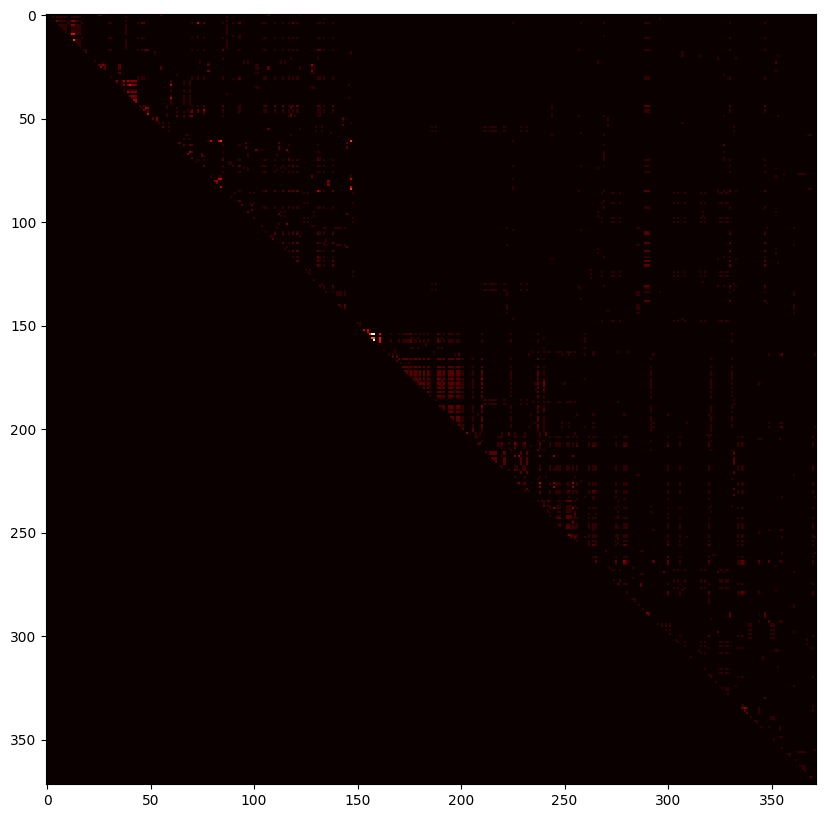

In [9]:
# show as image
plt.figure(figsize=(10, 10))
plt.imshow(shared_functions, interpolation="nearest", cmap="hot")
plt.show()

In [10]:
import networkx as nx
# import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# G = nx.from_scipy_sparse_array(sparse_shared.astype(int), create_using=nx.Graph)
G = nx.from_pandas_adjacency(shared_functions.astype(int), create_using=nx.Graph)
# G.remove_edges_from(nx.selfloop_edges(G))
len(G.edges)
# add node labels from dataframe index


2738

In [11]:
# Find largest connected component (if graph is fragmented)
largest_cc = max(nx.connected_components(G), key=len)
G_largest = G.subgraph(largest_cc).copy()
print(f"Largest component has {G_largest.number_of_nodes()} nodes and {G_largest.number_of_edges()} edges")# Basic network stats
print("Network statistics:")
print(f"Number of connected components: {nx.number_connected_components(G)}")
# print(f"Average clustering coefficient: {nx.average_clustering(G)}")
# print(f"Average path length: {nx.average_shortest_path_length(G_largest)}")  # Only on largest component

# Find most central nodes (shaders that share functions with many others)
centrality = nx.degree_centrality(G)
top_shaders = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nMost connected shaders:")
for shader, score in top_shaders:
    print(f"Shader {shader}: connected to {score:.4f} of network")

Largest component has 150 nodes and 1001 edges
Network statistics:
Number of connected components: 23

Most connected shaders:
Shader st2GR1: connected to 0.1294 of network
Shader wl3fDN: connected to 0.1267 of network
Shader ftfGW7: connected to 0.1267 of network
Shader tlVcDR: connected to 0.1240 of network
Shader fdK3RR: connected to 0.1240 of network
Shader 3ld3DM: connected to 0.1105 of network
Shader 3ltczj: connected to 0.1078 of network
Shader st23z1: connected to 0.1078 of network
Shader lsKcDD: connected to 0.1051 of network
Shader WdyXRD: connected to 0.1051 of network


In [12]:
list(G.edges(data=True))[:10]

[('ld23DV', '4djXDy', {'weight': 2}),
 ('ld23DV', '4sSXDV', {'weight': 2}),
 ('ld23DV', 'Ml3GR8', {'weight': 2}),
 ('ld23DV', 'WslGz4', {'weight': 2}),
 ('ld23DV', 'Wt2XzK', {'weight': 1}),
 ('ldBGDc', '4sfSR7', {'weight': 1}),
 ('ldBGDc', 'lsXXzN', {'weight': 1}),
 ('ldBGDc', 'MdsSRM', {'weight': 1}),
 ('ldBGDc', 'MsfXzM', {'weight': 1}),
 ('ldBGDc', 'XdsXz4', {'weight': 1})]

In [13]:
# find a smaller subgraph
def get_subgraph(G, min_size=5, max_size=400):
    for sg in nx.connected_components(G):
        if len(sg) > min_size and len(sg) < max_size:
            yield G.subgraph(sg)
        else:
            continue
    return None

subgraph_gen = get_subgraph(G)

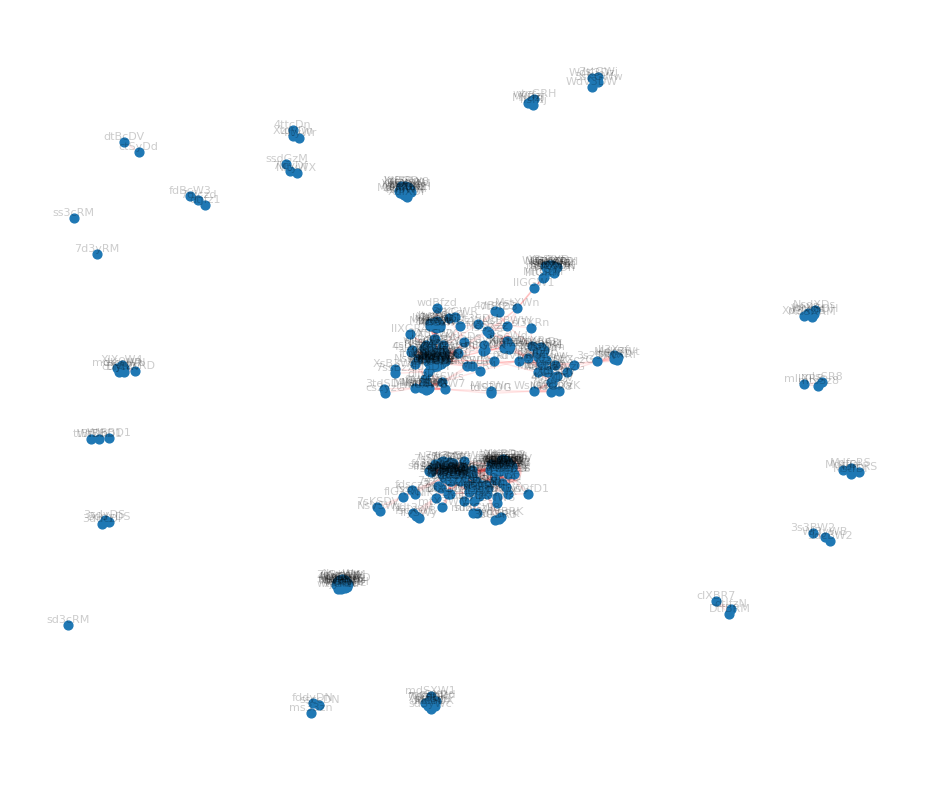

In [14]:
# subgraph = next(subgraph_gen)
# subgraph = G_largest
subgraph = G

# add direction by comparing publishing date of shaders
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(subgraph)#, seed=42)
# pos = nx.random_layout(subgraph, seed=42)
weight = [d["weight"] for _, _, d in subgraph.edges(data=True)]
nx.draw_networkx_edges(subgraph, pos, alpha=0.1, width=weight, edge_color="red", arrows=True, node_size=40, arrowsize=600)
nx.draw_networkx_nodes(subgraph, pos, node_size=40)
nx.draw_networkx_labels(subgraph, pos, font_size=8, verticalalignment="bottom", alpha=0.2)
plt.axis("off")
plt.show()

## interactive visualization with fastplotlib??

In [15]:
%gui qt

In [ ]:
import fastplotlib as fpl
from wgpu_shadertoy import Shadertoy
# from wgpu.gui.qt import WgpuWidget


fig = fpl.Figure(size=(450, 450), shape=(1,1))
# shader_canvas = WgpuWidget()


links = []
weights = []
for edge in subgraph.edges(data=True):
    start, stop, data = edge
    weights.append(data["weight"])
    links.append(np.array([pos[start], pos[stop]], dtype=np.float32))
    # fig[0,0].add_line(np.array([pos[start], pos[stop]], dtype=np.float32), thickness=weight, colors=col, alpha=0.2)

edges = fig[0,0].add_line_collection(links, thickness=weights, alpha=0.1, colors="cyan")
nodes = fig[0,0].add_scatter(data=np.array(list(pos.values()),dtype=np.float32), sizes=15, colors="white")
# nodes = fig[0,0].add_scatter(data=edges.data, sizes=15, colors="white") # sharing buffers might be possible by accessing the data inside the collection?: https://fastplotlib.org/ver/dev/_gallery/events/drag_points.html

fig[0,0].axes.visible = False
# img_view = fig[0,1].add_image(data=np.zeros((512, 512, 4), dtype=np.uint8), vmin=0, vmax=255)
# img_text = fig[0,0].add_text("Shader ID", font_size=20, anchor="top-left", offset=(-1, 1, 0))
# fig[0,1].axes.visible = False # call on the subplot, not the graphic!
# img_view.axes.visible = False


current_shader = None
# click on any node and highlight it plus all it's edges!
@nodes.add_event_handler("click")
def click_event(ev):
    global current_shader
    if ev.button != 1:
        return
    
    # first reset all colors
    nodes.colors = "white" #TODO: maybe cmap by author
    edges.colors = "cyan"

    vertex_index = ev.pick_info["vertex_index"]
    shader_id = list(subgraph.nodes(data=True))[vertex_index][0]
    print(vertex_index, shader_id)
    shader_data = df.loc[df["id"] == shader_id].head(1)
    nodes.colors[vertex_index] = "red"

    # now get all the edges and change their color too:
    for edge in subgraph.edges(shader_id, data=False):
        try:
            edge_index = list(subgraph.edges).index(edge)
        except ValueError:
            edge_index = list(subgraph.edges).index(edge[::-1])
        # print(edge_index, edge)
        edges[edge_index].colors = "orange"
        edges[edge_index].alpha = 0.5
        # TODO: color the neighbor node in yellow
        neighbor_id = list(pos.keys()).index(edge[1])
        nodes.colors[neighbor_id] = "yellow"

    # update the image?
    # new_frame = get_frame(shader_id)
    # img_view.data = new_frame
    # img_text.text = f"Shader ID: {shader_id}"
    fig[0,0].title = f"{shader_data.id.values[0]}: {shader_data.name.values[0]} by {shader_data.author.values[0]}"
    try:
        current_shader = _set_shader(shader_id, canvas=example.canvas)
        example.canvas.request_draw(current_shader._draw_frame)
        example.update()
    except Exception as e:
        print(f"Error: {e}")
        # shader = None
    # shader.show()

def get_frame(shader_data):
    #TODO: multipass shader? (do we have to reconstruct the json from the df or can we get it's source form somehow?)
    shader_code = shader_data.image_code.values[0]
    try:
        # avoid some common issues... still panics on some shaders -.-
        shader = Shadertoy(shader_code, inputs=shader_data.image_inputs.values[0], resolution=(512, 512), offscreen=True)
        snap = shader.snapshot()
        arr = np.asarray(snap)
        del shader
    except (Exception, RuntimeError) as e:
        print(f"Error: {shader_data.id.values[0]=}: \n{e}")
        arr = np.zeros((512, 512, 4), dtype=np.uint8)
        arr[:,:, 0] = 255 # red background
    return arr

def _set_shader(shader_id, canvas, device=None):
    shader_data = df.loc[df["id"] == shader_id].head(1)
    shader_code = shader_data.image_code.values[0]
    try:
        # avoid some common issues... still panics on some shaders -.-
        shader = Shadertoy(shader_code, resolution=(800, 450), canvas=canvas)
    except (Exception, RuntimeError) as e:
        print(f"Error: {shader_id=}: \n{e}")
        return None
    return shader


# fig.show()


In [ ]:
qt_widget = fig.show()

: 

In [ ]:
# test_example = false

# based on the example from Rendercanvas/wgpu-py: https://github.com/pygfx/rendercanvas/blob/main/examples/qt_app.py

"""
An example demonstrating a qt app with a Shadertoy inside.
"""
import importlib
import time

# Normally you'd just write e.g.
from PyQt6 import QtWidgets

# For the sake of making this example Just Work, we try multiple QT libs
# for lib in ("PySide6", "PyQt6", "PySide2", "PyQt5"):
#     try:
#         QtWidgets = importlib.import_module(".QtWidgets", lib)
#         break
#     except ModuleNotFoundError:
#         pass

from rendercanvas.qt import QRenderWidget

from wgpu_shadertoy import Shadertoy

class ExampleWidget(QtWidgets.QWidget):
    def __init__(self):
        super().__init__()
        self.resize(800+450, 450)
        self.setWindowTitle("qt app with two canvases?")

        splitter = QtWidgets.QSplitter()

        # TODO: make this button pause/resume the shader (can you suspend the loop?)
        self.canvas = QRenderWidget(splitter, update_mode="continuous")
        self.canvas2 = qt_widget # TODO: very hacky!


        splitter.addWidget(self.canvas)
        splitter.addWidget(self.canvas2) 
        # is the resolution the other way around?
        splitter.setSizes([800, 450])

        layout = QtWidgets.QHBoxLayout()
        layout.addWidget(splitter, 1)
        self.setLayout(layout)

        self.show()

# TODO: something more interesting
new_shader_code = """
void mainImage( out vec4 fragColor, in vec2 fragCoord )
{
    // Normalized pixel coordinates (from 0 to 1)
    vec2 uv = fragCoord/iResolution.xy;

    // Time varying pixel color
    vec3 col = 0.5 + 0.5*cos(iTime+uv.xyx+vec3(0,2,4));

    // Output to screen
    fragColor = vec4(col,1.0);
}
"""

app = QtWidgets.QApplication([])
example = ExampleWidget()

shader = Shadertoy(new_shader_code, resolution=(800,450), canvas=example.canvas)
example.canvas.request_draw(shader._draw_frame)
# the event loop is now handled by the QT app, so the shader.run() isn't needed anymore.

# Enter Qt event-loop (compatible with qt5/qt6)
app.exec() if hasattr(app, "exec") else app.exec_()

# fpl.loop.run()

163 WsyfRh
259 Ndt3zM
10 lsBXD1
22 ldBXDm


Matrix component[0] type Value(Vector { size: Quad, scalar: Scalar { kind: Float, width: 4 } })


130 wdKXzd
Error: shader_id='wdKXzd': 
Validation Error

Caused by:
  In wgpuDeviceCreateShaderModule, label = 'shadertoy_fragment <ImageRenderPass>'

Shader validation error: Function [0] 'hash' is invalid
  ┌─ shadertoy_fragment <ImageRenderPass>:1:1
  │
1 │
  │   naga::Expression [78]
  │
  │ naga::Function [0]
  │
  = Expression [78] is invalid
  = Composing 0's component type is not expected


      Function [0] 'hash' is invalid
        Expression [78] is invalid
          Composing 0's component type is not expected
Error: 'NoneType' object has no attribute '_draw_frame'
62 ll3Xzf


In [ ]:
subgraph.node("ct2cRD", data=False)

AttributeError: 'Graph' object has no attribute 'node'